# Stocastic Petri Net Analysis

- Evaluation for a stochastic model described by SPN/GSPN/MRSPN
- The tool `gospn` creates a marking graph (CTMC transition matrices)
- NMarkov uses the CTMC

## Install for gospn

- The repository: [https://github.com/okamumu/gospn](https://github.com/okamumu/gospn)
- Build with Go or download a binary directly from [https://github.com/okamumu/gospn/releases/tag/v0.9.0](https://github.com/okamumu/gospn/releases/tag/v0.9.0)
- Put the binary `gospn` to the directory

In [ ]:
;wget https://github.com/okamumu/gospn/releases/download/v0.9.0/gospn-0.9.0-linux-amd64.tar.gz

In [ ]:
;tar zxvf gospn-0.9.0-linux-amd64.tar.gz

## Install for NMarkov

Use Pkg to install the packages. The packages are located in GitHub. Please run the following commands:

- For Julia 1.0.5
```julia
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Origin.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Deformula.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SparseMatrix.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/NMarkov.jl.git"))
```

In [ ]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Origin.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/Deformula.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/SparseMatrix.jl.git"))
Pkg.add(PackageSpec(url="https://github.com/JuliaReliab/NMarkov.jl.git"))

## Initialize

Load packages

In [ ]:
using SparseArrays
using NMarkov
using Plots
using JuliaDot
using MAT

## Example: GSPN

Use the model: IaaS Cloud (monolithic)
```
  R. Ghosh, F. Longo, F. Frattini, S. Russo and K.S. Trivedi,
  Scalable analytics for IaaS cloud availability,
  IEEE Transactions on Cloud Computing, 2:1, 57-70, 2014.
```

### Draw a petrinet

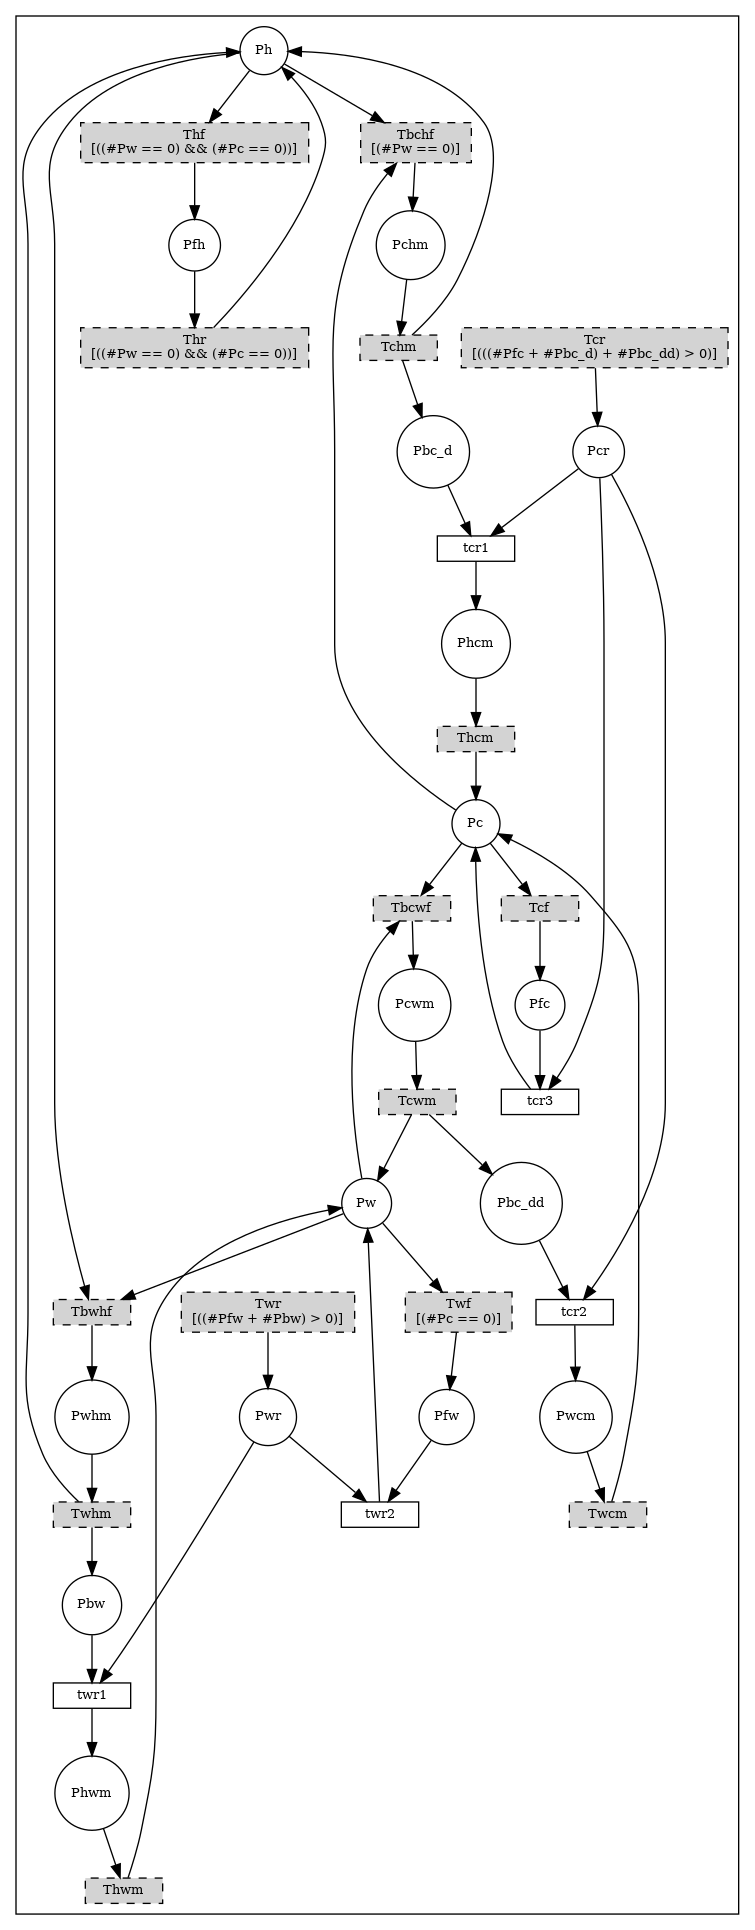

In [9]:
run(`./gospn view -i iaas_cloud.spn -o tmp.dot`)
data = open("tmp.dot") do f
   read(f, String)
end
draw(data) # JuliaDot.draw

### Generate the marking graph

In [16]:
run(`./gospn mark -i iaas_cloud.spn -o result.mat -t -g`)
matfile = matopen("result.mat")
keys(read(matfile))

# Crate marking...done
# computation time : 0.3860 (sec)
# # of total states         : 14110 (58991)
# # of total EXP/GEN states : 10272 (51196)
# # of total IMM states     : 3838 (7795)
# # of total ABS states     : 0 (0)
# (EXP)
#   # of EXP/GEN states ( G0) : 10272 (51196)
#   # of IMM states     ( I0) : 3838 (7795)

digraph { layout=dot; overlap=false; splines=true;
"0xc420314d10" [label="G0"];
"0xc4203156b0" [label="I0", style=filled];
"0xc420314d10"->"0xc420314d10" [label="E"];
"0xc420314d10"->"0xc4203156b0" [label="E"];
"0xc4203156b0"->"0xc420314d10" [label="I"];
}


Base.KeySet for a Dict{String,Any} with 21 entries. Keys:
  "rwdrwd6G0"
  "rwdavail3I0"
  "rwdrwd1G0"
  "rwdrwd5G0"
  "rwdrwd1I0"
  "initG0"
  "rwdrwd3I0"
  "initI0"
  "rwdavail1I0"
  "rwdrwd2G0"
  "I0G0I"
  "rwdrwd2I0"
  "G0G0E"
  "rwdrwd5I0"
  "rwdavail1G0"
  "rwdavail2G0"
  "rwdrwd3G0"
  "rwdavail3G0"
  "rwdrwd6I0"
  "rwdavail2I0"
  "G0I0E"

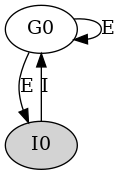

In [17]:
# Draw a group grapah
draw("""
digraph { layout=dot; overlap=false; splines=true;
"0xc420314d10" [label="G0"];
"0xc4203156b0" [label="I0", style=filled];
"0xc420314d10"->"0xc420314d10" [label="E"];
"0xc420314d10"->"0xc4203156b0" [label="E"];
"0xc4203156b0"->"0xc420314d10" [label="I"];
}""")

In the above graph, Gxx indicates EXP/GEN group where there is no enabled IMM transitions. Also Ixx indicates IMM group where there is one or more enabled IMM transitions. From the above graph, we find that there is no self-loop in I0. Then I0 can be vanished by
```
Q = G0G0E + G0I0E * I0G0I
```

In [24]:
# Read matrices
G0G0E = read(matfile, "G0G0E")
G0I0E = read(matfile, "G0I0E")
I0G0I = read(matfile, "I0G0I");

In [25]:
# CTMC transition matrix (IMM group should be vanished)
Q = G0G0E + G0I0E * I0G0I;

In [26]:
# initial probabiliyt vector
x0 = read(matfile, "initG0");

In [36]:
# load reward vector
r1 = read(matfile, "rwdrwd1G0"); #Ph
r2 = read(matfile, "rwdrwd2G0"); #Pw
r3 = read(matfile, "rwdrwd3G0"); #Pc

In [60]:
# expected number of hot/warm/cold servers in steady state
pis, conv, = stgs(Q)
println("Convergence ", conv)
println("# of hot servers ", sum(pis .* r1)) # this value is doubtful...
println("# of warm servers ", sum(pis .* r2))
println("# of cold servers ", sum(pis .* r3))

Convergence true
# of hot servers 1.1241117025494665
# of warm servers 2.999859013045915
# of cold servers 2.999894287384514


In [62]:
# Transient
ts = LinRange(0.0, 50.0, 100)
irwd, crwd, xt, cxt = tran(Q, x0, r2, ts, forward=:T);

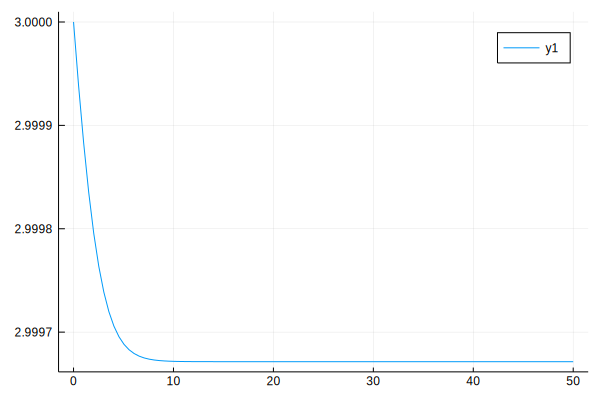

In [63]:
plot(ts, irwd)